# Imports

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.path import Path
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mtick




import cobra
#import cobra.test
from cobra import Metabolite, Reaction, Model
from cobra.util.array import create_stoichiometric_matrix
from cobra.util.solver import linear_reaction_coefficients
from cobra.flux_analysis import flux_variability_analysis
from benpy import vlpProblem
from benpy import solve as bensolve
from scipy.sparse import lil_matrix
from scipy.spatial import Delaunay
from scipy.spatial import distance

from functools import reduce 

import scipy.io as sio
from cobra.io.mat import _cell 
from collections import OrderedDict

from operator import itemgetter

from full_ecosystem import Ecosystem
from eco_utils import *

# Funciones para clusterizar puntos

In [2]:
from sklearn.cluster import DBSCAN, OPTICS,SpectralClustering, AffinityPropagation

from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy

def getHIERARCHICALclusters(dvector,k=20,lmethod='ward',criterion='maxclust', **kwards):
    row_linkage = hierarchy.linkage(dvector, method=lmethod)
    clusters = fcluster(row_linkage, k, criterion=criterion)
    return k, clusters

def getDBSCANclusters(dmatrix,eps = 0.05, min_samples = 5, **kwards): 
    
    # eps : 
    # The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
    # This is not a maximum bound on the distances of points within a cluster. This is the most important 
    # DBSCAN parameter to choose appropriately for your data set and distance function.
 
    # min_samples:
    # The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. 
    # This includes the point itself.
    
    dbscan = DBSCAN(eps=eps, min_samples = min_samples,metric='precomputed',**kwards)
    clusters = dbscan.fit_predict(dmatrix) 
    
    #output incluye outliers, valor -1 en vector clusters
    k = len(np.unique(clusters))
    
    cluster_ids = list(np.arange(k)+1)
    cluster_db_ids = list(np.unique(clusters))
    cluster_dict = dict(zip(cluster_db_ids, cluster_ids))
    if -1 in cluster_dict:
        print("outliers: cluster %d" % cluster_dict[-1])
    clusters = [cluster_dict[x] for x in clusters]
    clusters = np.array(clusters)
    
    return k,clusters
    
def getOPTICSclusters(dmatrix, max_eps=0.05, min_samples = 5, **kwards):
    optics = OPTICS(max_eps=max_eps, min_samples = min_samples,metric='precomputed')
    clusters = optics.fit_predict(dmatrix)
    k = len(np.unique(clusters))

def getSCclusters(dmatrix,assign_labels= "discretize",random_state=0,k=20, delta=0.2, **kwards):

    
    #transformación de matriz de distancia a matriz de similitud. Vía aplicación de Gaussian (RBF, heat) kernel:
    sim_matrix = np.exp(- dmatrix ** 2 / (2. * delta ** 2))
    
    sc = SpectralClustering(n_clusters=k, assign_labels=assign_labels, 
                            random_state=random_state,affinity='precomputed', **kwards)
    sc_results = sc.fit_predict(sim_matrix)
    #clusters = sc_results.labels_
    clusters = sc_results
    return k, clusters   

def getAPclusters(dmatrix, delta=0.2, **kwards):
    af = AffinityPropagation(**kwards)
    #sim_matrix = np.exp(- dmatrix ** 2 / (2. * delta ** 2))
    af_matrix = dmatrix
    af_results = af.fit_predict(af_matrix)
    #clusters = af_results.labels_
    clusters = list(af_results)
    k = len(np.unique(clusters))
    return k, clusters




## Toy example

In [3]:
###NEW TOY

from cobra import Model, Reaction, Metabolite
#Organism 1:
model = Model('org1')

#A_ext -> A
reaction = Reaction('Atr')
model.add_reaction(reaction)
reaction.build_reaction_from_string('A_e -> A_c')

reaction = Reaction('EX_A')
model.add_reaction(reaction)
reaction.build_reaction_from_string('A_e -> ')
reaction.lower_bound = -1000

#B_ext -> B
reaction = Reaction('Btr')
model.add_reaction(reaction)
reaction.build_reaction_from_string('B_e -> B_c')


#EX_B
reaction = Reaction('EX_B')
model.add_reaction(reaction)
reaction.build_reaction_from_string('B_e -> ')

#A -> E
reaction = Reaction('AE')
model.add_reaction(reaction)
reaction.build_reaction_from_string('A_c -> E_c')

#A -> D
reaction = Reaction('AD')
model.add_reaction(reaction)
reaction.build_reaction_from_string('A_c -> D_c')

#D -> G
reaction = Reaction('DG')
model.add_reaction(reaction)
reaction.build_reaction_from_string('D_c -> 4 G_c')

#E->G
reaction = Reaction('EG')
model.add_reaction(reaction)
reaction.build_reaction_from_string('E_c -> 2 G_c')


#B-> 10G
reaction = Reaction('BG')
model.add_reaction(reaction)
reaction.build_reaction_from_string('B_c -> 10 G_c')

#G-> bio
reaction = Reaction('Gbio')
model.add_reaction(reaction)
reaction.build_reaction_from_string('G_c -> biom1_c')


reaction = Reaction('biomass')
model.add_reaction(reaction)
reaction.build_reaction_from_string('biom1_c ->')

model.objective = 'biomass'
for m in model.metabolites:
    m.compartment = m.id[-1]
    
cobra.io.write_sbml_model(model, "org1.xml")



#Organism 2:
model = Model('org2')

#A_ext -> A
reaction = Reaction('Atr')
model.add_reaction(reaction)
reaction.build_reaction_from_string('A_e -> A_c')

reaction = Reaction('EX_A')
model.add_reaction(reaction)
reaction.build_reaction_from_string('A_e -> ')
reaction.lower_bound = -1000



#EX_B
reaction = Reaction('EX_B')
model.add_reaction(reaction)
reaction.build_reaction_from_string('B_e -> ')

#A -> B
reaction = Reaction('AB')
model.add_reaction(reaction)
reaction.build_reaction_from_string('A_c -> B_c')

#B -> Bext
reaction = Reaction('Btr')
model.add_reaction(reaction)
reaction.build_reaction_from_string('B_c -> B_e')


#B -> C
reaction = Reaction('BC')
model.add_reaction(reaction)
reaction.build_reaction_from_string('B_c -> 10 C_c')

#C -> biom
reaction = Reaction('Cbio')
model.add_reaction(reaction)
reaction.build_reaction_from_string('C_c -> biom2_c')

reaction = Reaction('biomass')
model.add_reaction(reaction)
reaction.build_reaction_from_string('biom2_c -> ')
model.objective = 'biomass'
for m in model.metabolites:
    m.compartment = m.id[-1]

cobra.io.write_sbml_model(model, "org2.xml")

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
unknown metabolite 'A_e' created
unknown metabolite 'A_c' created
unknown metabolite 'B_e' created
unknown metabolite 'B_c' created
unknown metabolite 'E_c' created
unknown metabolite 'D_c' created
unknown metabolite 'G_c' created
unknown metabolite 'biom1_c' created
unknown metabolite 'A_e' created
unknown metabolite 'A_c' created
unknown metabolite 'B_e' created
unknown metabolite 'B_c' created
unknown metabolite 'C_c' created
unknown metabolite 'biom2_c' created


In [4]:
member_prefixes = ['org1','org2']
member_models = []

for member in member_prefixes:
    mmodel = cobra.io.read_sbml_model("%s.xml" % (member))
    member_models.append(mmodel)

eco2_model = Ecosystem(models = member_models, prefixes=member_prefixes, 
                     community_name = 'toy-example', community_id = 'org1-org2', solver='gurobi')


0. Copying member models ...
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp2nz9wat5.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpmtxhj4oj.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros
1. Storing exchanged metabolites information ...
2. Updating member model objects ids ...
3. Storing member objectives ...
4. Merging member models ...
5. Creating pool compartment, metabolites and reactions ...
6. Updating compartment names ...
Done. Community model created
Created community model from 2 member models:
General stats:
model (0):
	 id = org1, name =  , prefix= org1
		 reactions = 11
		 exchange metabolites = 3
		 compartments = 2
model (1):
	 id = org2, name =  , prefix= org2
		 reactions = 8
		 exchange metabolites = 3
		 compartments = 2
community model:
	 id = org1-org2, name = toy-example 
		 reactions = 23
		 exchange metabolite

In [5]:
#NEW TOY
eco2_model.cmodel.remove_reactions(['EX_biom1_c', 'EX_biom2_c'])
reaction = Reaction('bio1Com')
eco2_model.cmodel.add_reaction(reaction)
reaction.build_reaction_from_string('biom1_c_pool -> bio_com_pool')

reaction = Reaction('bio2Com')
eco2_model.cmodel.add_reaction(reaction)
reaction.build_reaction_from_string('biom2_c_pool -> bio_com_pool')

reaction = Reaction('com_growth')
eco2_model.cmodel.add_reaction(reaction)
reaction.build_reaction_from_string('bio_com_pool -> ')


eco2_model.cmodel.objective = 'com_growth'
#Condiciones de simulacion
eco2_model.set_pool_bounds({'A_e':(-10,1000)}, bioCons=-20) #name_scenario = 'test'

eco2_model.set_pool_bounds({'B_e':(0,1000)}, bioCons=-20)

unknown metabolite 'bio_com_pool' created


In [6]:
for r in eco2_model.cmodel.reactions:
    print(r)

org1_Atr: org1_A_e --> org1_A_c
org1_EX_A: org1_A_e <=> A_e_pool
org1_Btr: org1_B_e --> org1_B_c
org1_EX_B: org1_B_e <=> B_e_pool
org1_AE: org1_A_c --> org1_E_c
org1_AD: org1_A_c --> org1_D_c
org1_DG: org1_D_c --> 4.0 org1_G_c
org1_EG: org1_E_c --> 2.0 org1_G_c
org1_BG: org1_B_c --> 10.0 org1_G_c
org1_Gbio: org1_G_c --> org1_biom1_c
org1_biomass: org1_biom1_c --> biom1_c_pool
org2_Atr: org2_A_e --> org2_A_c
org2_EX_A: org2_A_e <=> A_e_pool
org2_EX_B: org2_B_e <=> B_e_pool
org2_AB: org2_A_c --> org2_B_c
org2_Btr: org2_B_c --> org2_B_e
org2_BC: org2_B_c --> 10.0 org2_C_c
org2_Cbio: org2_C_c --> org2_biom2_c
org2_biomass: org2_biom2_c --> biom2_c_pool
EX_A_e: A_e_pool <=> 
EX_B_e: B_e_pool --> 
bio1Com: biom1_c_pool --> bio_com_pool
bio2Com: biom2_c_pool --> bio_com_pool
com_growth: bio_com_pool --> 


In [7]:
eco2_model.cmodel

Name,org1-org2
Memory address,0x07fa8b5550d30
Number of metabolites,19
Number of reactions,24
Number of groups,0
Objective expression,1.0*com_growth - 1.0*com_growth_reverse_ddd67
Compartments,"org1 e, org1 c, org2 e, org2 c, Community pool"


In [8]:
eco2_model.set_cluster_reactions()

Missing FCA results
Using non-blocked reactions only
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpv96cyn6u.lp
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp985_7xjr.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpkzujkxy1.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic 

In [10]:
eco2_model.build_grid(numPoints = 10, expand = True, drop_zero=True)

Maximum community:100.0
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
[  0.          11.11111111  22.22222222  33.33333333  44.44444444
  55.55555556  66.66666667  77.77777778  88.88888889 100.        ]
[[[  0.           0.11111111   0.22222222   0.33333333   0.44444444
     0.55555556   0.66666667   0.77777778   0.88888889   1.        ]
  [  0.           0.11111111   0.22222222   0.33333333   0.44444444
     0.55555556   0.66666667   0.77777778   0.88888889   1.        ]
  [  0.           0.11111111   0.22222222   0.33333333   0.44444444
     0.55555556   0.66666667   0.77777778   0.88888889   1.        ]
  [  0.           0.11111111   0.22222222   0.33333333   0.44444444
     0.55555556   0.66666667   0.77777778   0.88888889   1.        ]
  [  0.           0.11111111   0.22222222   0.33333333   0.44444444
     0.55555556   0.66666667   0.77777778   0.88888889   1.        ]
  [  0.           0.11111111   0.22222222   0

In [11]:
eco2_model.get_member_reactions()

In [12]:
eco2_model.get_points_distribution()

In [13]:
eco2_model.analyze_grid(analysis = 'feasibility', update_bounds=True)

[0.11111111 0.        ]
updating reaction bounds ...
[0.22222222 0.        ]
updating reaction bounds ...
[0.33333333 0.        ]
updating reaction bounds ...
[0.44444444 0.        ]
updating reaction bounds ...
[0.55555556 0.        ]
updating reaction bounds ...
[0.66666667 0.        ]
updating reaction bounds ...
[0.77777778 0.        ]
updating reaction bounds ...
[0.88888889 0.        ]
updating reaction bounds ...
[1. 0.]
updating reaction bounds ...
[ 0.         11.11111111]
updating reaction bounds ...
[ 0.11111111 11.11111111]
updating reaction bounds ...
[ 0.22222222 11.11111111]
updating reaction bounds ...
[ 0.33333333 11.11111111]
updating reaction bounds ...
[ 0.44444444 11.11111111]
updating reaction bounds ...
[ 0.55555556 11.11111111]
updating reaction bounds ...
[ 0.66666667 11.11111111]
updating reaction bounds ...
[ 0.77777778 11.11111111]
updating reaction bounds ...
[ 0.88888889 11.11111111]
updating reaction bounds ...
[ 1.         11.11111111]
updating reaction 

In [14]:
oldRxn2Cluster = eco2_model.rxn2cluster
newRxn2Cluster = [r for r in oldRxn2Cluster if 'EX_' in r] #all exchanges
eco2_model.rxn2cluster = newRxn2Cluster
eco2_model.analyze_grid(analysis = 'qual_fva', update_bounds=True)

Running qualitative fva over grid feasible points...
[0.11111111 0.        ]
updating reaction bounds ...
running FVA on grid point...
(array([0.11111111, 0.        ]), array([0.11111111, 0.88888889]))
Academic license - for non-commercial use only - expires 2023-06-15
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpftocqvu8.lp
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpmk4sxrhh.lp
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp56glv8bl.lp
Reading time = 0.00 seconds
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
: 20 rows, 

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpsann1u8b.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpkvcfz6in.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp8f1x7da4.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpba1dz877.lp
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpto8iqf2b.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp4dqtpqfj.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6w

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpja8pi922.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmplvbwnh6n.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpt3_g0kd2.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
translating to qualitative vector..
[ 0.77777778 11.11111111]
updating reaction bounds ...
running FVA on grid point...
(array([ 0.77777778, 11.11111111]), array([0.77777778, 0.2

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpmwr50wc4.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpw7ntp72o.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpef5tzzyj.lp
Reading time = 0.01 seconds
: 20 rows, 49 columns, 93 nonzeros
translating to qualitative vector..
[ 0.22222222 22.22222222]
updating reaction bounds ...
running FVA on grid point...
(array([ 0.22222222, 22.22222222]), array([0.22222222, 0.7

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpnzmpj90l.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpjk4iahbu.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpeemrvafh.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-

Academic license - for non-commercial use only - expires 2023-06-15
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpkohv07oi.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp_200rhtf.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmphfrgga93.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp4zq808q9.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpsy_0qn9x.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpuo6688zv.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6w

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmptecvr_a5.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpg9o7im0r.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpkfo7ras_.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurob

translating to qualitative vector..
[ 0.66666667 44.44444444]
updating reaction bounds ...
running FVA on grid point...
(array([ 0.66666667, 44.44444444]), array([0.66666667, 0.33333333]))
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmprlk2297x.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpj9u74k55.lp
Reading time = 0.01 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpr2mjpb3t.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 9

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp61w5isnn.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpnmxaaxu5.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmperhosqks.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6w

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp2l1s9oym.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp5n_ez2kk.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp0spj19vo.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6w

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpr1ogwlq8.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpjnvtf7e1.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp9s4c7w21.lp
Reading time = 0.01 seconds
: 20 rows, 49 columns, 93 nonzeros
translating to qualitative vector..
[ 0.77777778 66.66666667]
updating reaction bounds ...
running FVA on grid point...
(array([ 0.77777778, 66.66666667]), array([0.77777778, 0.2

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp_dozos_0.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpqkxmdwce.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpdm7ht7as.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-

Academic license - for non-commercial use only - expires 2023-06-15
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp8dkok5th.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmph96d_boo.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpx1slmizd.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
translating to qualitative vector..
[ 0.22222222 88.88888889]
updating reaction bounds ...
running FVA on grid point...
(array([ 0.22222222, 88.88888889]), array([0.22222222, 0.7

Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only - expires 2023-06-15
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp25qtt_ys.lp
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpnmpukc0d.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpp6ztr50f.lp
Reading time = 0.00 seconds
: 20 rows, 49 columns, 93 nonzeros
Academic license - for non-commercial use only - expires 2023-06-15
Using license file /Users/natjimenez/gurobi.lic
Read LP format model from file /var/folders/61/gwbtk7290yn0j6w

In [ ]:
eco2_model

In [14]:
file_dir = '.'
#name_scenario = '30bioConsA'
name_scenario = '10Abc20'
#name_community_model = 'toy_3103'
#name_community_model = 'toy_0504'
#name_community_model = 'toyOrigS'
name_community_model = 'toy_0804'

# Load files pickle

In [15]:
file_dir = '.'
batch_size = 250

#Puntos factibles:
#eco2_model.feasible_points = get_feasible_points_from_batch_files(eco2_model, file_dir,name_scenario,name_community_model, batch_size)

eco2_model.feasible_points = get_feasible_points_from_batch_files(eco2_model, file_dir,name_scenario,name_community_model, batch_size)


print(name_community_model+'_'+name_scenario)

toy_0804_10Abc20


In [16]:
eco2_model.qual_vector_df  = get_qual_fva_from_batch_files(eco2_model, file_dir,name_scenario,name_community_model, batch_size)


In [17]:
eco2_model.fva = get_fva_from_batch_files(eco2_model, file_dir,name_scenario,name_community_model, batch_size)

In [18]:
eco2_model.qual_vector_df.head()

,EX_A_e,EX_B_e,bio1Com,bio2Com,com_growth,org1_AD,org1_AE,org1_Atr,org1_BG,org1_Btr,...,org1_Gbio,org1_biomass,org2_AB,org2_Atr,org2_BC,org2_Btr,org2_Cbio,org2_EX_A,org2_EX_B,org2_biomass
0,-1,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,-1,1,0
1,-1,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,-1,1,0
2,-1,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,-1,1,0
3,-1,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,-1,1,0
4,-1,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,-1,1,0


In [19]:
#Filter points where u_com = 0 and f_wen = 0 and f_wen = 1
zero_index = [i for i,p in enumerate(eco2_model.points) if p[1]==0]
p_1 = [i for i,p in enumerate(eco2_model.pfractions) if p[0]==1]
p_0 = [i for i,p in enumerate(eco2_model.pfractions) if p[0]==0]


#update feasible_points
index_remove = zero_index + p_1+p_0
index_rm_df = index_remove
new_fp = eco2_model.feasible_points
for i,p in enumerate(eco2_model.feasible_points):
    if i in index_remove:
        if new_fp[i] == False:
            index_rm_df.remove(i)
        new_fp[i] = False


eco2_model.feasible_points = new_fp
#"update" feasible points. All points in index_remove should be False
#update qual_df
eco2_model.qual_vector_df.drop(index_rm_df, axis=0, inplace=True)

# Grid analysis

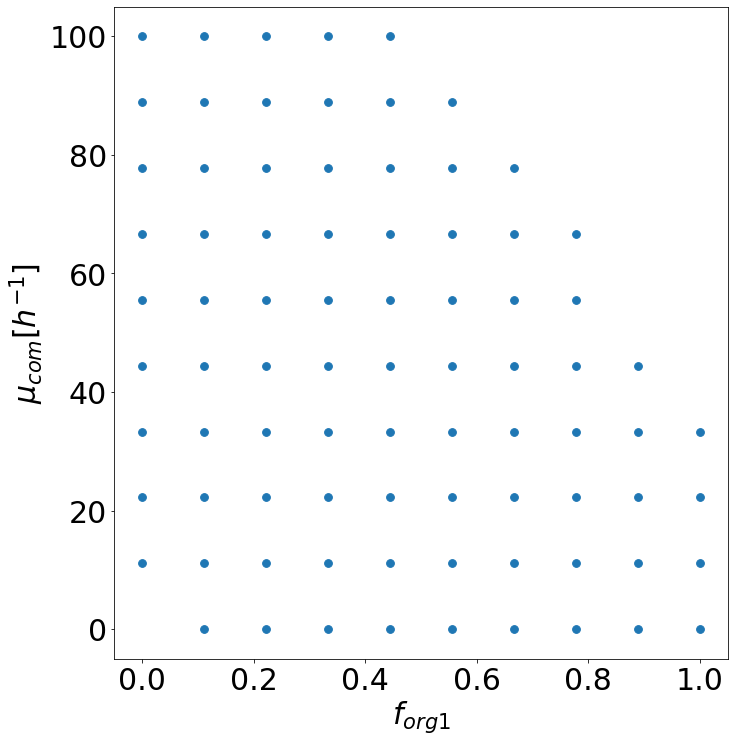

In [15]:
plt.rcParams.update({'font.size': 30})

eco2_model.plot_2D_slice(prefixes=[], fixed_values=[], parent_cmap='tab20',s=60, figsize=(11,12), 
                         to_plot = None, show_edge=False,frac_prefix= None,
                            xlabel = '$f_{org1}$',
                            ylabel ='$\mu_{com}[h^{-1}]$', saveFile = 'grid')#, fractions=[0.6,0.4],  )

## Clustering

Parameters for function **clusterPoints**:
- **method**: method used for clustering. Default: *hierarchical* clustering with Jaccard distance.
- **numeric_delta**: difference between flux values accepted as zero(default: 1e-4).
- **k**: number of clusters to be obbtained (default: 20).

In [16]:
eco2_model.clusterPoints('hierarchical', k = 8)
#aux = {'clusters':biomin2_model.clusters, 
#       'qual_vector_df':biomin2_model.qual_vector_df}

#pickle.dump(aux, open( 'biomin2_fva_clustering.p', "wb" ) )

Calculating jaccard distances between grid points...
Clustering grid points ...
Done!


Esta función genera los siguientes atributos:
- **k**: Número de clusters (default: 20)
- **clusters**: Array que indica a qué cluster pertenece cada punto -factible- de la grilla.

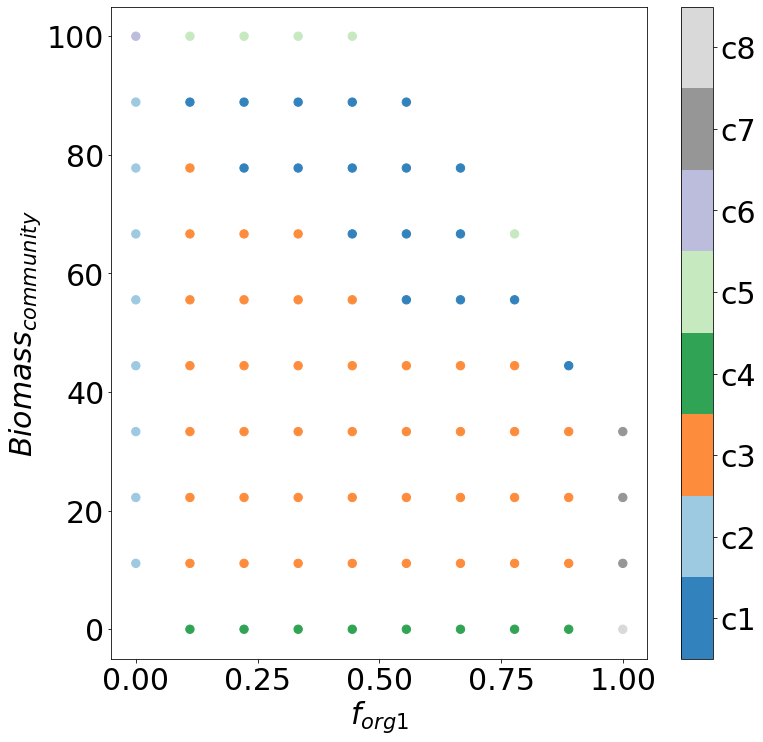

In [18]:
plt.rcParams.update({'font.size': 30})
#print(name_community_model+'_sce_'+name_scenario)
#eco2_model.plot_2D_slice(prefixes=[], fixed_values=[], parent_cmap='tab20c',s=70, figsize=(12,12), 
#                         to_plot = 'cluster', show_edge=False,frac_prefix= None,
#                            xlabel = '$f_{org1}$',
#                            ylabel ='$\mu_{com} [h^{-1}]$', saveFile='clusters')#, fractions=[0.6,0.4],  )

eco2_model.plot_2D_slice(prefixes=[], fixed_values=[], parent_cmap='tab20c',s=70, figsize=(12,12), 
                         to_plot = 'cluster', show_edge=False,frac_prefix= None,
                            xlabel = '$f_{org1}$',
                            ylabel ='$Biomass_{community}$', saveFile='clusters_toy')#, fractions=[0.6,0.4],  )

#plt.xlabel('$\mu\'_{\it{A. ferrooxidans}}\quad[gDW_{wen}/gDW_c/h]$')
#gDWi/gDWc/h
#fontweight='bold'
#plt.ylabel('$\mu\'_{\it{T. sulfidooxidans}}\quad[gDW_{cut}/gDW_c/h]$')



To search for reactions that change their qualitative values between two clusters:

**1. Select representative values for each reaction on each cluster**:

The function **get_cluster_reaction_values** gives a DataFrame where each column is a cluster and each row a reaction. For each reaction it stores its representative value (for each cluster), in other words a qualitative vaues that represts over a threshold fraction of the points of the cluster. If there are no enough points in a cluster where a certain qualitative state is exhibited the cell is filled with a *NaN* value.
    
Parameters of **get_cluster_reaction_values**:
- **thr**:  Minimum fraction of cluster points where a reaction should have the same qualitative state to be considered representative (default value: 0.75) 
- **changing**: Fill the DataFrame only with reactions which representative values are different in at least 2 clusters (default: True).
    
**2. Select reactions with qualitative representative values between two clusters:**    
  
The function **compare_clusters** gives a DataFrame with reactions and their status that change between two specific clusters.

Parameters **get_cluster_reactions**:
- **cluster_df**: DataFrame generated by  **get_cluster_reaction_values**
- **cid1, cid2**: Ids of clusters to be compared


In [23]:
df = eco2_model.get_cluster_reaction_values(thr=0.8, changing= True)
cat_dict = {-3.0: '-', -2.0: '--',-1.0: '-0',1.0: '0+',0.0: '0',2.0: '++',3.0: '+',4.0: '-+',5.0: 'err',100.0: 'var'}
df = df.replace(cat_dict)
df.head()

,c1,c2,c3,c4,c5,c6,c7,c8
EX_A_e,--,--,--,-0,-,-,--,0
EX_B_e,0+,0+,0+,0+,0,0,0,0
org1_EX_A,-0,0,-0,0,0,0,--,0
org1_EX_B,--,0,-0,0,-,0,0,0
org2_EX_A,--,--,--,-0,-,-,0,0


In [30]:
dftrans = df.replace(cat_dict)

In [31]:
dftrans

,c1,c2,c3,c4,c5,c6,c7,c8
EX_A_e,--,--,--,-,-,--,--,--
EX_B_e,0+,0+,0+,0,0,0+,0+,0+
org1_AD,0+,++,0+,+,0,0+,++,0+
org1_AE,0+,0+,0+,0,0,0+,0+,0+
org1_Atr,0+,++,++,+,0,0+,++,++
org1_BG,0+,0+,0+,+,+,++,++,++
org1_Btr,0+,0+,0+,+,+,++,++,++
org1_DG,0+,++,0+,+,0,0+,++,0+
org1_EG,0+,0+,0+,0,0,0+,0+,0+
org1_EX_A,-0,--,--,-,0,-0,--,--


In [24]:
df_comp = eco2_model.compare_clusters(eco2_model.get_cluster_reaction_values(thr=0.8, changing= True), 'c4','c2')

# Functional relationship analysis

In [30]:
def fraction_to_normalize(point_fractions, reaction):
    #from point_fraction computes which element of this array should be used for normalization
    #reaction: string reaction id
    if reaction.startswith('org1_'):
        fraction = point_fractions[0]
    elif reaction.startswith('org2_'):
        fraction = point_fractions[1]
    else: 
        print('No org detected, asumming community reaction')
        fraction =1
        
    return(fraction)
    


In [31]:
grid_x = [0.2, 0.4, 0.6, 0.8]
#grid_y = reversed([0.02, 0.04, 0.06, 0.08, 0.12])
grid_y = reversed([20, 40, 60])
feasible_points = eco2_model.points[eco2_model.feasible_points]
analyze_points = []
for y in grid_y:
    for x in grid_x:
        search_point = [x, y]
        distances = np.linalg.norm(feasible_points-search_point, axis=1)
        min_index = np.argmin(distances)
        analyze_points.append(min_index)
        print(f"the closest point to {search_point} is {feasible_points[min_index]}, at a distance of {distances[min_index]}")

the closest point to [0.2, 60] is [ 0.22222222 55.55555556], at a distance of 4.4444999996527805
the closest point to [0.4, 60] is [ 0.44444444 55.55555556], at a distance of 4.444666661111387
the closest point to [0.6, 60] is [ 0.55555556 55.55555556], at a distance of 4.444666661111387
the closest point to [0.8, 60] is [ 0.77777778 55.55555556], at a distance of 4.4444999996527805
the closest point to [0.2, 40] is [ 0.22222222 44.44444444], at a distance of 4.4444999996527805
the closest point to [0.4, 40] is [ 0.44444444 44.44444444], at a distance of 4.444666661111387
the closest point to [0.6, 40] is [ 0.55555556 44.44444444], at a distance of 4.444666661111387
the closest point to [0.8, 40] is [ 0.77777778 44.44444444], at a distance of 4.4444999996527805
the closest point to [0.2, 20] is [ 0.22222222 22.22222222], at a distance of 2.2223333305556934
the closest point to [0.4, 20] is [ 0.44444444 22.22222222], at a distance of 2.222666622231108
the closest point to [0.6, 20] is [

In [32]:
eco2_model.cmodel.reactions

[<Reaction org1_Atr at 0x7fa8b56529d0>,
 <Reaction org1_EX_A at 0x7fa8b5652a30>,
 <Reaction org1_Btr at 0x7fa8b5652b80>,
 <Reaction org1_EX_B at 0x7fa8b5652c10>,
 <Reaction org1_AE at 0x7fa8b5652dc0>,
 <Reaction org1_AD at 0x7fa8b5652e80>,
 <Reaction org1_DG at 0x7fa8b5652f40>,
 <Reaction org1_EG at 0x7fa8b565b0a0>,
 <Reaction org1_BG at 0x7fa8b565b1f0>,
 <Reaction org1_Gbio at 0x7fa8b565b280>,
 <Reaction org1_biomass at 0x7fa8b565b340>,
 <Reaction org2_Atr at 0x7fa8b5660d90>,
 <Reaction org2_EX_A at 0x7fa8b5660df0>,
 <Reaction org2_EX_B at 0x7fa8b5660f40>,
 <Reaction org2_AB at 0x7fa8b55787f0>,
 <Reaction org2_Btr at 0x7fa8b55785b0>,
 <Reaction org2_BC at 0x7fa8b5667190>,
 <Reaction org2_Cbio at 0x7fa8b5667250>,
 <Reaction org2_biomass at 0x7fa8b5667310>,
 <Reaction EX_A_e at 0x7fa8b56527f0>,
 <Reaction EX_B_e at 0x7fa8b566d760>,
 <Reaction bio1Com at 0x7fa8b5673f10>,
 <Reaction bio2Com at 0x7fa8acd3bf70>,
 <Reaction com_growth at 0x7fa8b56733a0>]

In [33]:
import copy

#select point (I'm going to do it relative to the clusters as before)
#this_point = total_points[3] #relative to cluster
rxns_analysis = ['org1_EX_A', 'org2_EX_A']
print(rxns_analysis)


maxmin_data = []
for this_point in analyze_points:
    model = copy.deepcopy(eco2_model)
    feasible_points = model.points[model.feasible_points]
    this_point_coords = feasible_points[this_point]
    print('Selected point'+str(this_point_coords))
    print('This point coords '+str(this_point_coords))
    this_point_frac = [this_point_coords[0], 1-this_point_coords[0]]
    print('This point frac '+str(this_point_frac))
    point = [this_point_coords[0]*this_point_coords[1], (1-this_point_coords[0])*this_point_coords[1]] #equivalent to old grid
    print('Old grid point '+str(point))

    #update bounds
    for i, member in enumerate(model.prefixes):
        mfrac = this_point_frac[i]
        mrxns = model.member_rxns[member]

        for rid in mrxns:
            r = model.cmodel.reactions.get_by_id(rid)
            old_bounds = r.bounds
            r.bounds = (old_bounds[0]*mfrac, old_bounds[1]*mfrac)

    for ix, member_objectives in enumerate(model.objectives):
        new_bounds = (point[ix], point[ix])

        for rid in member_objectives.keys():
            rxn = model.cmodel.reactions.get_by_id(rid)
            rxn.bounds = new_bounds

    try:
        #define limits reactions based on theoretical max-min defined from model
        rxn_ref_fva = flux_variability_analysis(model.cmodel, reaction_list = rxns_analysis[0])

        #define range reactions
        values_rxn_ref = np.linspace(rxn_ref_fva['minimum'][0], rxn_ref_fva['maximum'][0], num=50)
        values_rmax = []
        values_rmin = []

        with model.cmodel as cmodel:
            for val in values_rxn_ref:
                rxn = cmodel.reactions.get_by_id(rxns_analysis[0])
                rxn.bounds = (val,val)
                #compute max min
                fva = flux_variability_analysis(cmodel, reaction_list = rxns_analysis[1])
                for i, el in enumerate(fva):
                    row_dict = dict()
                    row_dict[rxns_analysis[0]] = val/fraction_to_normalize(this_point_frac, rxns_analysis[0])
                    row_dict[rxns_analysis[1]] = fva[el][0]/fraction_to_normalize(this_point_frac, rxns_analysis[1])
                    row_dict['FVA'] = el
                    row_dict['point'] = str([round(this_point_coords[0],3), round(this_point_coords[1],3)])
                    maxmin_data.append(row_dict)
                #store values 
                #values_rmax.append(fva['maximum'][0])
                #values_rmin.append(fva['minimum'][0])

    except:
        print('\n Issues with '+str(this_point_coords)+' unfeasible?')

    #divide by f_i
    #if rxns_analysis[1].startswith('wen'):
    #    values_rmax = values_rmax/this_point_frac[0]
    #    values_rmin = values_rmin/this_point_frac[0]
    #    values_rxn_ref = values_rxn_ref/this_point_frac[0]
    #elif rxns_analysis[1].startswith('cut'):
    #    values_rxn_ref = values_rxn_ref/this_point_frac[1]
    #    values_rmax = values_rmax/this_point_frac[1]
    #    values_rmin = values_rmin/this_point_frac[1]




['org1_EX_A', 'org2_EX_A']
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp3jh15yxx.lp
Reading time = 0.00 seconds
: 19 rows, 48 columns, 90 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpu2ouka24.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpcnvzkznz.lp
Reading time = 0.00 seconds
: 6 rows, 16 columns, 26 nonzeros
Selected point[ 0.22222222 55.55555556]
This point coords [ 0.22222222 55.55555556]
This point frac [0.2222222222222222, 0.7777777777777778]
Old grid point [12.345679012345679, 43.20987654320988]
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmp5evjhzdr.lp
Reading time = 0.00 seconds
: 19 rows, 48 columns, 90 nonzeros
Read LP format model from file /var/folders/61/gwbtk7290yn0j6wky05t7_tm0000gn/T/tmpb2ual6yr.lp
Reading time = 0.00 seconds
: 8 rows, 22 columns, 38

In [34]:
maxmin_df = pd.DataFrame(maxmin_data)
maxmin_df.head()

,org1_EX_A,org2_EX_A,FVA,point
0,-20.000000,-7.142857,minimum,"[0.222, 55.556]"
1,-20.000000,-5.555556,maximum,"[0.222, 55.556]"
2,-19.591837,-7.259475,minimum,"[0.222, 55.556]"
3,-19.591837,-5.555556,maximum,"[0.222, 55.556]"
4,-19.183673,-7.376093,minimum,"[0.222, 55.556]"


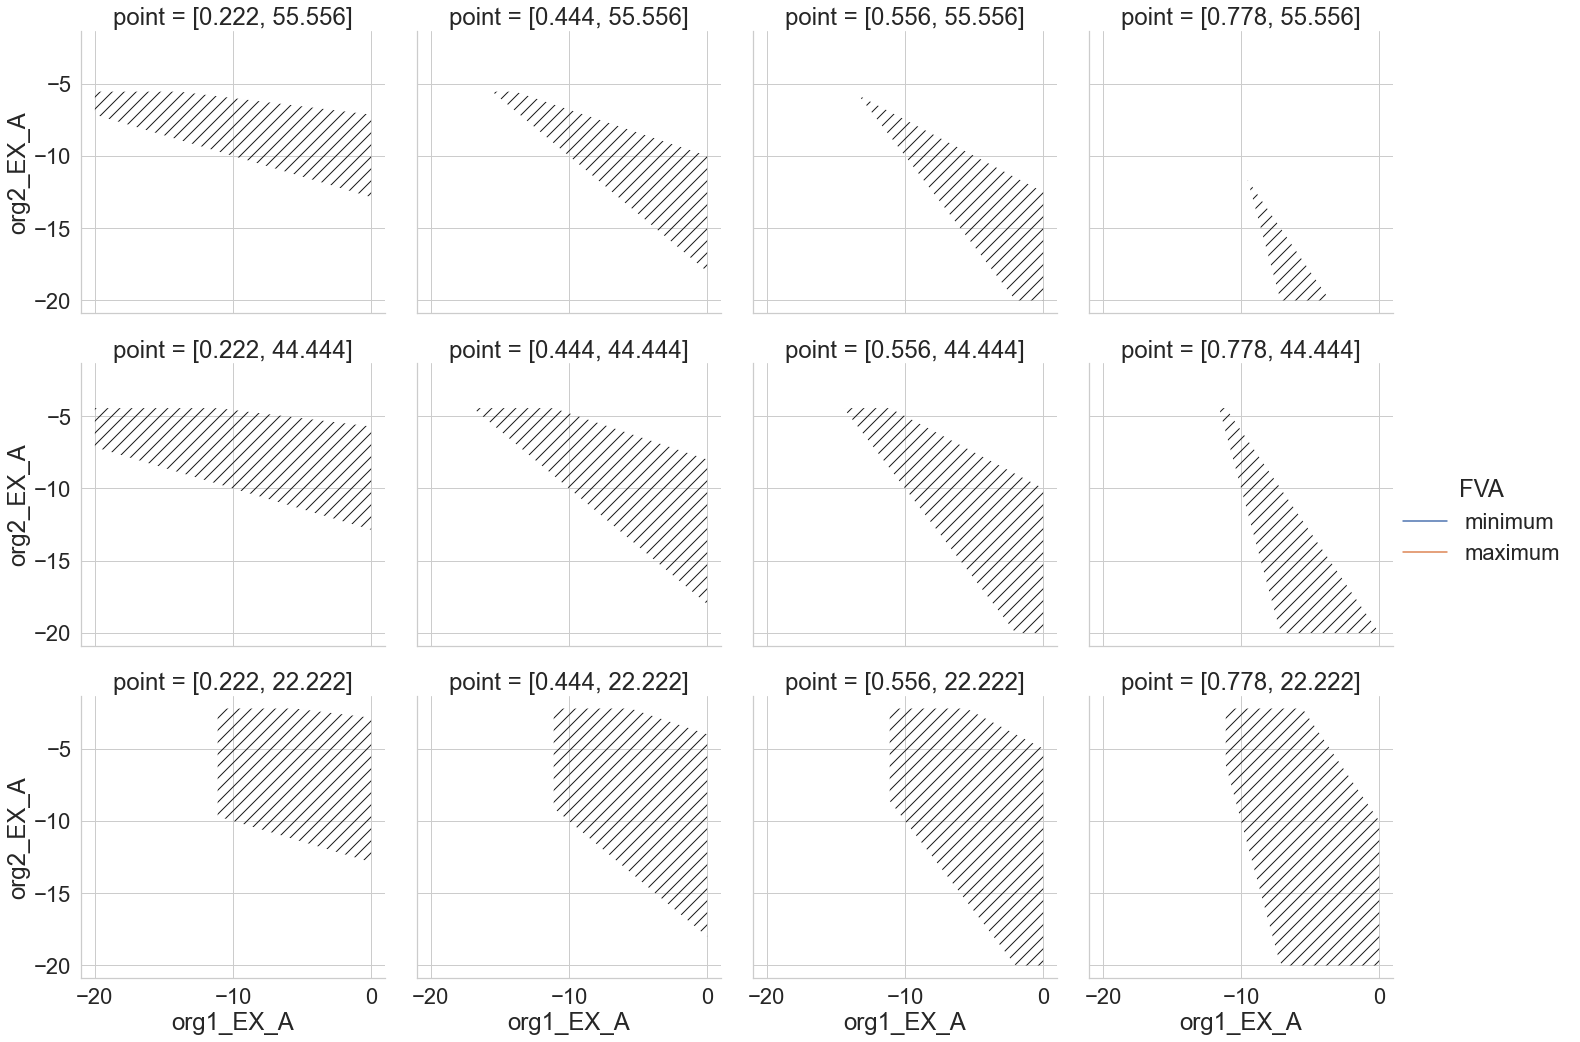

In [38]:
import seaborn as sns
sns.set(font_scale = 2)

sns.set_style("whitegrid")

g=sns.relplot(data = maxmin_df, x=rxns_analysis[0], y=rxns_analysis[1], col = 'point', hue='FVA', kind='line', col_wrap=4, lw=0)
points = maxmin_df.point.unique()
for i,ax in enumerate(g._axes):
    p = points[i]

    p_df = maxmin_df.loc[maxmin_df['point']==p]
    x = p_df.loc[p_df['FVA']=='maximum'][rxns_analysis[0]].to_numpy()

    y1 = p_df.loc[p_df['FVA']=='maximum']
    y1 = y1[rxns_analysis[1]].to_numpy()

    y2 = p_df.loc[p_df['FVA']=='minimum']
    y2 = y2[rxns_analysis[1]].to_numpy()

    ax.fill_between(x, y1,y2, color='none',hatch='//', edgecolor="k", linewidth=0.001)
    
